In [348]:
from pylab import *
import seaborn as sns
import os
import pandas as pd
import numpy as np
%matplotlib inline

In [349]:
sns.set_context('paper')

In [350]:
from keras.models import model_from_json

In [351]:
json_name = '../src/architecture_2016-08-06-14-35.json'
weight_name = '../src/model_weights_2016-08-06-14-35.h5'
model = model_from_json(open(json_name).read())
model.load_weights(weight_name)

In [352]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model structure

In [353]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

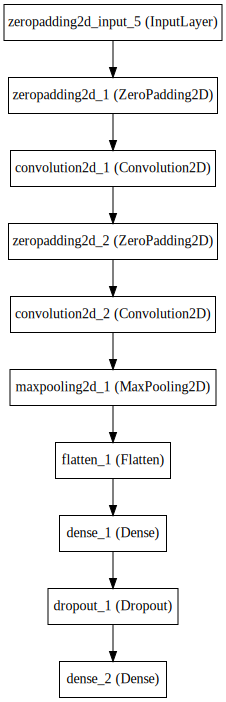

In [354]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Training history

In [355]:
history = pd.read_csv('../src/history_2016-08-06-14-35.csv')

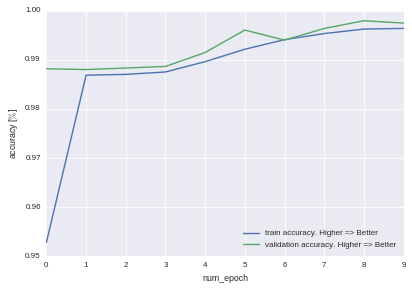

In [356]:
plot(history['acc'], label='train accuracy. Higher => Better')
plot(history['val_acc'], label='validation accuracy. Higher => Better')
legend(loc='lower right')
xlabel('num_epoch')
ylabel('accuracy [$\%$]')
savefig('accuracy.png')

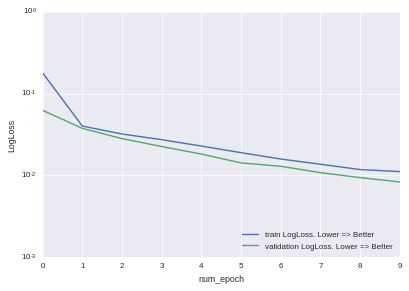

In [357]:
plot(history['loss'], label='train LogLoss. Lower => Better')
plot(history['val_loss'], label='validation LogLoss. Lower => Better')
legend(loc='lower right')
xlabel('num_epoch')
ylabel('LogLoss')
yscale('log')
savefig('LogLoss.png')

# Model performance on the test set

In [358]:
from keras.preprocessing.image import ImageDataGenerator

In [359]:
img_rows, img_cols = 64, 64

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_path = '../data/test'
test_generator = test_datagen.flow_from_directory(
                                                        test_path,
                                                        target_size=(img_rows, img_cols),
                                                        class_mode='binary')

Found 6393 images belonging to 2 classes.


In [360]:
(log_loss_score, accuracy_score) = model.evaluate_generator(test_generator, test_generator.N)

In [361]:
'log_loss_score = ', log_loss_score

('log_loss_score = ', 0.014433901161286119)

In [362]:
'accuracy_score = ', accuracy_score

('accuracy_score = ', 0.99405599874863126)

In [363]:
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, accuracy_score

In [364]:
def extract_datetime(x):
    return x.split('.')[1].split('+')[0]    

In [365]:
test_path = '../data/test'

In [366]:
up_test_path = os.path.join(test_path, 'up')

In [367]:
down_test_path = os.path.join(test_path, 'down')

In [368]:
result = []
up_files = os.listdir(up_test_path)
for file_name in up_files:
    result += [cv2.imread(os.path.join(up_test_path, file_name))]
    
down_files = os.listdir(down_test_path)
for file_name in down_files:
    result += [cv2.imread(os.path.join(down_test_path, file_name))]

In [369]:
result = np.array(result).transpose((0, 3, 1, 2))

In [370]:
prediction = model.predict(result)

In [371]:
df = pd.DataFrame()

In [372]:
df['filename'] = up_files + down_files

In [373]:
df['prediction'] = prediction

In [374]:
df['state'] = 0

In [375]:
df.loc[:len(up_files), 'state'] = 1

In [376]:
df['datetime'] = pd.to_datetime(df['filename'].apply(extract_datetime))

In [377]:
df = df.sort_values(by='datetime')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  if __name__ == '__main__':


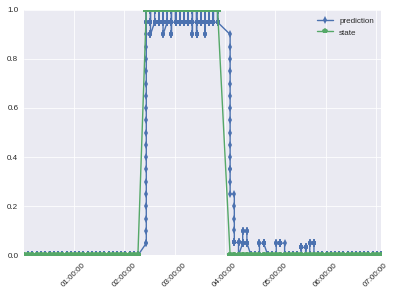

In [378]:
plot(df['datetime'].values[:2000], pd.rolling_mean(df['prediction'].values[:2000], 20), 'd-', label='prediction')
plot(df['datetime'].values[:2000], df['state'].values[:2000], 'p-', label='state')
xticks(rotation=45)
legend(loc='upper right')
savefig('rolling_mean.png')

In [379]:
roc_auc_score(df['state'].values, df['prediction'])

0.98593182957373837